In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import glob

In [6]:
# combine and sort files
q = "Data/final_tmdb_data*.csv.gz"
chunked_files = sorted(glob.glob(q))
# Showing the first 5 
chunked_files

['Data\\final_tmdb_data_2000.csv.gz',
 'Data\\final_tmdb_data_2001.csv.gz',
 'Data\\final_tmdb_data_2002.csv.gz',
 'Data\\final_tmdb_data_2003.csv.gz',
 'Data\\final_tmdb_data_2004.csv.gz',
 'Data\\final_tmdb_data_2010.csv.gz',
 'Data\\final_tmdb_data_2011.csv.gz',
 'Data\\final_tmdb_data_2012.csv.gz']

In [3]:
## Loading and Concatenating the list of dfs
df_combined = pd.concat([pd.read_csv(file, index_col=0) for file in chunked_files])
df_combined.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,Two neighbors become intimate after discoverin...,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.117,2200.0,PG


In [9]:
# Exclude movies with 0 for budget and revenue
df = df_combined[(df_combined.revenue > 0) & (df_combined.budget > 0)]
df[['revenue', 'budget']].head(10)

,revenue,budget
imdb_id,,
tt0118694,12854953.0,150000.0
tt0120467,14904.0,120000.0
tt0120630,224834564.0,45000000.0
tt0120753,105983.0,8000000.0
tt0120755,546388105.0,125000000.0
tt0120903,296339527.0,75000000.0
tt0120913,36754634.0,75000000.0
tt0120917,169327687.0,100000000.0
tt0122459,36609995.0,24000000.0


### Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

Null Hypothesis:  Different MPAA rating (G/PG/PG-13/R) all have the same revenue. (the revenue is not significantly different between MPAA rating)

Alternative Hypothesis: Different MPAA rating (G/PG/PG-13/R) have different revenue. (the revenuw is significantly different between MPAA rating)

Using an alpha=.05

Test Used: ANOVA

In [51]:
# create a copy of df
df_clean = df.copy()

In [52]:
# Remove NAN from certification
df_clean.dropna(subset= 'certification', inplace=True)

In [53]:
# only 4 rating are required (G/PG/PG-13/R)
# Remove 'NC-17' and NR from certification(4 movies fall in NC-17 rating) 

df_clean = df_clean[~df_clean['certification'].isin(['NC-17','NR'])]

In [54]:
# different MPAA rating available
df_clean['certification'].unique()

array(['PG', 'R', 'G', 'PG-13'], dtype=object)

In [55]:
# Create groups dictionary.
groups = {}
## Loop through all unique categories
for i in df_clean['certification'].unique():
    ## Get series for group and rename
    data = df_clean.loc[df['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data

In [56]:
groups.keys()

dict_keys(['PG', 'R', 'G', 'PG-13'])

### Testing Assumptions

In [57]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}

In [58]:
## convert to a dataframe(Transpose form- row to col)
norm_results_df = pd.DataFrame(norm_results).T  
norm_results_df

,n,p,test stat
PG,174.0,2.740871e-18,80.876512
R,571.0,2.760734e-96,440.065345
G,34.0,2.139270e-08,35.320432
PG-13,508.0,1.515066e-80,367.582697


In [59]:
### checking normality with pandas 
norm_results_df['normal'] = norm_results_df['p'] > .05 
norm_results_df

,n,p,test stat,normal
PG,174.0,2.740871e-18,80.876512,False
R,571.0,2.760734e-96,440.065345,False
G,34.0,2.139270e-08,35.320432,False
PG-13,508.0,1.515066e-80,367.582697,False


The distribution for each MPAA rating is not normal but since size(n) for each distribution is greater than 15 we can safely move to the next stage

In [60]:
### Testing Assumption of Equal Variance

# with the * operator 
result = stats.levene(*groups.values())
result

LeveneResult(statistic=24.96186384539605, pvalue=1.0676370907699397e-15)

In [61]:
result.pvalue < 0.05

True

We met the assumption of equal variance.

### One-Way ANOVA Test
Now that we have checked the assumptions, we will perform the test.

In [62]:
#  the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=36.13733900072907, pvalue=2.025818095164767e-22)

In [63]:
result.pvalue < 0.05

True

Since our pvalue is less than alpha it means the null hypothesis can be rejected and we have a significant result. The result validate the claim that different MPAA rating (G/PG/PG-13/R) have different revenue.

**Tukey's Pairwise Multiple Comparisons Test**

In [67]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
values = df_clean['revenue']
labels = df_clean['certification']

In [68]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,-11233350.9713,0.9833,-90219030.6945,67752328.7519,False
G,PG-13,-43038917.8091,0.4477,-117659580.8557,31581745.2376,False
G,R,-126079654.1252,0.0001,-200441634.9384,-51717673.312,True
PG,PG-13,-31805566.8378,0.1207,-68806824.1804,5195690.5048,False
PG,R,-114846303.154,0.0,-151323061.2592,-78369545.0487,True
PG-13,R,-83040736.3162,0.0,-108732362.0735,-57349110.5588,True


The summary shows that we only have significant result for G & R, PG & R and PG-13 & R. The other comparisons didnt give us a significant result and equally indicate that the null hypothesis shouldn't be rejected as there are no statistical difference.

In [73]:
df_clean.groupby('certification')['revenue'].mean().sort_values(ascending= False).index

certification
G        1.798502e+08
PG       1.686168e+08
PG-13    1.368113e+08
R        5.377054e+07
Name: revenue, dtype: float64

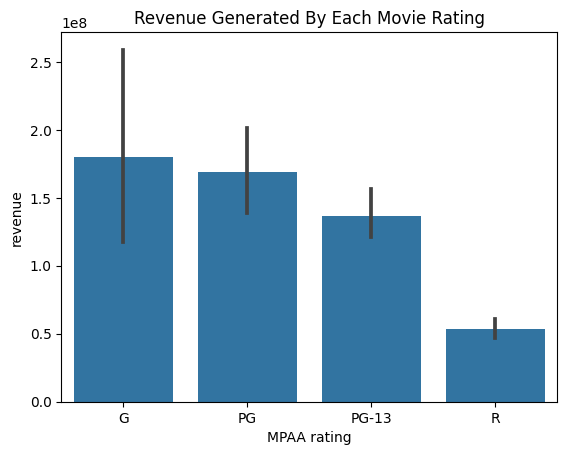

In [127]:
# visual
plot_color = sns.color_palette()[0]
plot_order = df_clean.groupby('certification')['revenue'].mean().sort_values(ascending= False).index
sns.barplot(data= df_clean, x= 'certification', y= 'revenue', color= plot_color, order= plot_order)
plt.xlabel('MPAA rating')
plt.title('Revenue generated by each movie rating'.title());

The visual reveals that movies with G rating earns the highest revenue

### Q2: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

Hypothesis:

+ Null Hypothesis: There are no significant difference in revenue for different movie duration or runtime
+ Alternate Hypothesis: There is a significant difference in revenue for different movie duration or runtime
+ Significance Level (Alpha): For this test, our alpha value is 0.05
+ Test Used : Tee-Test

In [85]:
# Filtering out movies with runtime over 150min(2.5 hours) and those with  90min(1.5 hours) long or less
long_duration_df = df_clean[df_clean.runtime >= 150]
shorter_duration_df = df_clean[df_clean.runtime <= 90]

In [93]:
# Define feature of interest
long_duration_revenue = long_duration_df['revenue']
shorter_duration_revenue = shorter_duration_df['revenue']

###  Check for and remove outliers

In [88]:
# Check for outliers in revenue for long_duration movies
zscores= stats.zscore(long_duration_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [112]:
# Check for outliers in revenue for short duration movies
zscores= stats.zscore(shorter_duration_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [113]:
# remove outliers for nonsmokers group
shorter_duration_revenue = shorter_duration_revenue[(abs(stats.zscore(shorter_duration_revenue)) < 3)]

### Normality Test

In [114]:
# test the long duration group for normality
result_long_duration_revenue = stats.normaltest(long_duration_revenue)
result_long_duration_revenue

NormaltestResult(statistic=8.62715804905673, pvalue=0.013385556526158695)

In [116]:
result_long_duration_revenue.pvalue > 0.05

False

In [118]:
# test the short duration group for normality
result_short_duration_revenue = stats.normaltest(shorter_duration_revenue)
result_short_duration_revenue

NormaltestResult(statistic=37.58087934234341, pvalue=6.909008679561399e-09)

In [119]:
result_short_duration_revenue.pvalue > 0.05

False

Our p-values for both groups are well below 0.05 which means our data is NOT normally distributed. However, our our sample size is large enough to proceed without satisfying this test. For an independent t test, sample sizes of 15 per group are considered sufficient.

### Check for Equal Variance

In [123]:
# Test for equal variance
result = stats.levene(long_duration_revenue, shorter_duration_revenue)
result

LeveneResult(statistic=88.43365313963427, pvalue=9.412375747940261e-18)

In [124]:
result.pvalue < 0.05

True

We don't have equal variances. Since pvalue is less than alpha we reject the Null hypothesis which states that the variance for both groups are equal and make equal_var = False when performing t-test

In [125]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(long_duration_revenue, shorter_duration_revenue, equal_var = False)
result

Ttest_indResult(statistic=4.052020518633995, pvalue=0.00023239843499194216)

In [126]:
result.pvalue < 0.05

True

Our p value < alpha (0.05), so we reject the null hypothesis and accept that there is a significant difference in revenue generated for longer movie duration and shorter movie duration

In [129]:
new_df = df_clean.copy()

In [131]:
# create a discount status
new_df['duration_status'] = pd.cut(x= new_df['runtime'],
                                   bins= [0, 90, np.max(new_df['runtime'])], 
                                   labels= ['Short Duration', 'Long Duration'])

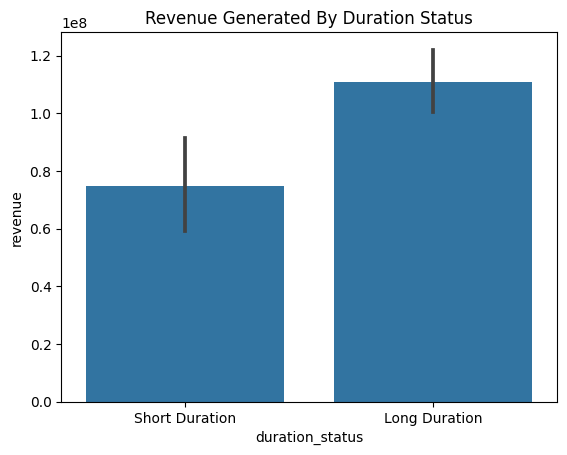

In [133]:
# let's visualize the revenue by duration status
ax = sns.barplot(data=new_df, x='duration_status', y='revenue', color= plot_color)
ax.set_title('Revenue generated by duration status'.title());

Visual reveals that longer duration movie generate more revnue than shorter duration movies